# Transformer 실습

이번 실습에서는 감정 분석 task에 RNN 대신 Transformer를 구현하여 적용해 볼 것입니다.
Library import나 dataloader 생성은 RNN 실습 때와 똑같기 때문에 설명은 넘어가도록 하겠습니다.

In [1]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

Using cache found in C:\Users\suzuk/.cache\torch\hub\huggingface_pytorch-transformers_main
C:\Users\suzuk\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from torch import nn
from math import sqrt


class MultiHeadAttention(nn.Module):
    #input_dim = 임베딩 차원 / d_model = q,k,v가 가질 차원의 크기
  def __init__(self, input_dim, d_model, n_heads):
    super().__init__()
    try:
        self.input_dim = input_dim
        self.d_prime_model = int(round(d_model/n_heads,0))
        self.n_heads = n_heads
    except round(d_model/n_heads,0) % n_heads is not 0:
        print('round(d_model/n_heads,0) % n_heads is not 0')
        
    self.wq = nn.Linear(input_dim, d_model) #쿼리벡터 생성
    self.wk = nn.Linear(input_dim, d_model) #키 벡터 생성
    self.wv = nn.Linear(input_dim, d_model) #밸류 벡터 생성
    self.dense = nn.Linear(d_model, d_model) #어텐션 최종 out 을 위해.
    self.softmax = nn.Softmax(dim=-1)
    

  def forward(self, x, mask):   
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    # B S H D' 에서 B H S D'으로 변경 필요
    # B S H D' 은 batch 안에 sequentioal가 key인 H vs D' 행렬이 존재하므로 Head가 종속적
    # B H S D'은 batch 안에 head가 key 인 S vs D' 행렬이 존재 하므로 Head가 독립적
    q = q.view(q.shape[0], q.shape[1], self.n_heads, self.d_prime_model).transpose(1,2)
    k = k.view(k.shape[0], k.shape[1], self.n_heads, self.d_prime_model).transpose(1,2)
    v = v.view(v.shape[0], v.shape[1], self.n_heads, self.d_prime_model).transpose(1,2)

    # B H S D' * B H D' S = B H S S
    # 각 head에 따른 상관도를 확인 가능
    score = torch.matmul(q, k.transpose(-1, -2)) 
    score = score / sqrt(self.d_prime_model)
    
    if mask is not None:
    #마스크가 있다면 실행, 마스크가 있는곳은 1로 되어져있으므로 가장 작은수를 곱하고 더함
    #soft max 함수 이후에 0에 근사함
    #mask(B S S) 와 현 score(B H S S) 텐서 형식이 다르므로 통일 해줘야함.
        mask = mask.unsqueeze(1)
    #unsqueeze를 통해 B 1 S S로 만듬
        score = score + (mask * -1e9)

    score = self.softmax(score) # B H S S
    result = torch.matmul(score, v) # B H S D'
    result = result.transpose(1,2).contiguous()
    result = result.view(result.shape[0], result.shape[1], -1) # B S D
    result = self.dense(result)
    return result

<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\suzuk\AppData\Local\Temp\ipykernel_10368\2979245485.py:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  except round(d_model/n_heads,0) % n_heads is not 0:


In [4]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff, dropout):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.MHA = MultiHeadAttention(input_dim, d_model, 4)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )
    self.dropout1 = nn.Dropout(p=dropout)  # 적절한 p 값을 설정
    self.dropout2 = nn.Dropout(p=dropout)  # 적절한 p 값을 설정

    self.layer_norm1 = nn.LayerNorm(d_model)  # Layer Normalization 정의
    self.layer_norm2 = nn.LayerNorm(d_model)  # Layer Normalization 정의

  def forward(self, x, mask):
    x1 = self.MHA(x, mask)
    x1 = self.dropout1(x1)
    x1 = self.layer_norm1(x1 + x)

    x2 = self.ffn(x)
    x2 = self.dropout2(x2)
    x2 = self.layer_norm2(x2 + x1)

    return x2

In [5]:
import numpy as np

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


In [6]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, dropout):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, dropout) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 1)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]
    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x


In [7]:
from torch.optim import Adam

lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [12]:
train_acc_list = []
test_acc_list = []

def train_and_test(n_epochs, dropout):
    model = TextClassifier(len(tokenizer), 32, 5, 32, dropout)
    model = model.to('cuda')
    optimizer = Adam(model.parameters(), lr=lr)
    
    n_epochs = n_epochs

    for epoch in range(n_epochs):
        total_loss = 0.
        model.train()
        
        for data in train_loader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda').float()
            preds = model(inputs)[..., 0]
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
      
        print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")
        
        with torch.no_grad():
            model.eval()
            train_acc = accuracy(model, train_loader)
            test_acc = accuracy(model, test_loader)
            print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")
            train_acc_list.append(train_acc*100)
            test_acc_list.append(test_acc*100)

In [13]:
import numpy as np
train_and_test(50, 0.4)

Epoch   0 | Train Loss: 217.69080284237862
=========> Train acc: 0.812 | Test acc: 0.781
Epoch   1 | Train Loss: 151.5949199348688
=========> Train acc: 0.877 | Test acc: 0.820
Epoch   2 | Train Loss: 127.35777093470097
=========> Train acc: 0.908 | Test acc: 0.830
Epoch   3 | Train Loss: 103.54092540591955
=========> Train acc: 0.909 | Test acc: 0.819
Epoch   4 | Train Loss: 83.85744083300233
=========> Train acc: 0.954 | Test acc: 0.837
Epoch   5 | Train Loss: 65.89293328486383
=========> Train acc: 0.969 | Test acc: 0.836
Epoch   6 | Train Loss: 54.17129115015268
=========> Train acc: 0.977 | Test acc: 0.833
Epoch   7 | Train Loss: 42.05539043992758
=========> Train acc: 0.982 | Test acc: 0.830
Epoch   8 | Train Loss: 33.30220951512456
=========> Train acc: 0.988 | Test acc: 0.828
Epoch   9 | Train Loss: 28.776422660332173
=========> Train acc: 0.987 | Test acc: 0.827
Epoch  10 | Train Loss: 26.267842879518867
=========> Train acc: 0.990 | Test acc: 0.829
Epoch  11 | Train Loss: 21.

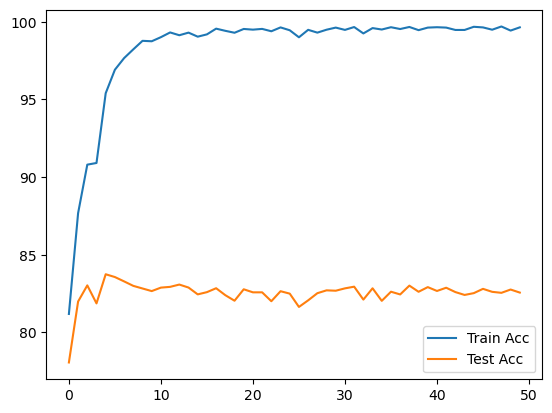

In [14]:
plt.plot(train_acc_list, label = 'Train Acc')
plt.plot(test_acc_list, label = 'Test Acc')
plt.legend()
plt.show()